In [31]:
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from PIL import Image
import torch
import numpy as np

from torch.utils.data import DataLoader, Dataset
import os
DATA_ROOT = "/home/zohra/pythonCode/data_machnet"

In [ ]:
class SARRARP50Dataset(Dataset):
    def __init__(self, root_dir, split="train", image_size=512, num_classes=10):
        self.root_dir = root_dir
        self.image_size = image_size
        self.num_classes = num_classes

        # Get all video directories for the split
        if split == "train":
            split_dirs = ["train1", "train2"]
        else:  # test
            split_dirs = ["test"]

        self.image_paths = []
        self.mask_paths = []

        for split_dir in split_dirs:
            split_path = os.path.join(root_dir, split_dir)
            if not os.path.exists(split_path):
                continue

            # Get all video directories
            video_dirs = [
                d
                for d in os.listdir(split_path)
                if os.path.isdir(os.path.join(split_path, d))
            ]

            for video_dir in video_dirs:
                rgb_dir = os.path.join(split_path, video_dir, "rgb")
                seg_dir = os.path.join(split_path, video_dir, "segmentation")

                if os.path.exists(rgb_dir) and os.path.exists(seg_dir):
                    # Get all image files
                    rgb_files = sorted(glob.glob(os.path.join(rgb_dir, "*.png")))

                    for rgb_file in rgb_files:
                        filename = os.path.basename(rgb_file)
                        seg_file = None

                        base_name = os.path.splitext(filename)[0]
                        potential_seg = os.path.join(seg_dir, base_name + ".png")
                        if os.path.exists(potential_seg):
                            seg_file = potential_seg

                        if seg_file:
                            self.image_paths.append(rgb_file)
                            self.mask_paths.append(seg_file)

        print(f"{split} dataset: {len(self.image_paths)} images found")

        # Transforms
        self.transform = transforms.Compose(
            [
                transforms.Resize((image_size, image_size)),
                transforms.ToTensor(),
                transforms.Normalize(
                    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
                ),
            ]
        )

        self.mask_transform = transforms.Compose([
        transforms.Resize((image_size, image_size), interpolation=transforms.InterpolationMode.NEAREST),
        transforms.PILToTensor()  # keeps integer values
        ])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Load image
        image = Image.open(self.image_paths[idx]).convert("RGB")
        image = self.transform(image)

        # Load mask
        mask = Image.open(self.mask_paths[idx])
        if mask.mode != "L":
            mask = mask.convert("L")

        mask = self.mask_transform(mask)  # shape [1,H,W], integer values
        mask = mask.squeeze(0).long()
        # mask = mask.long().squeeze(0)  # keep class indices as-is (0–9)
        # mask = torch.clamp(mask, 0, self.num_classes - 1)  # Ensure valid class range

        return image, mask


In [42]:

train_dataset = SARRARP50Dataset(
        DATA_ROOT, split="train", image_size=512, num_classes=10
    )


train dataset: 13043 images found


In [43]:
loader = DataLoader(train_dataset, batch_size=2, shuffle=True)


Image batch shape: torch.Size([2, 3, 512, 512])
Mask batch shape: torch.Size([2, 512, 512])


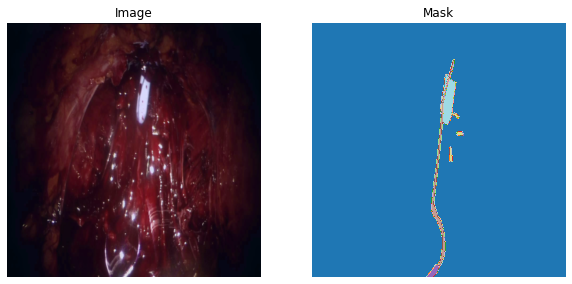

In [44]:
for imgs, masks in loader:
    print("Image batch shape:", imgs.shape)  # [B, C, H, W]
    print("Mask batch shape:", masks.shape)  # [B, H, W]

    # Visualize first image and mask in batch
    img = imgs[0].permute(1, 2, 0).numpy()  # convert to HWC
    img = (img - img.min()) / (img.max() - img.min())  # normalize to 0-1 for plt
    mask = masks[0].numpy()

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title("Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap="tab20")
    plt.title("Mask")
    plt.axis("off")
    plt.show()
    break


In [36]:
print(np.unique(mask))


[0 1 2 3 4 5 8]
